# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn

import os


# Load Dataset :    noisy_image

#### - Load Noisy image ( targe image )

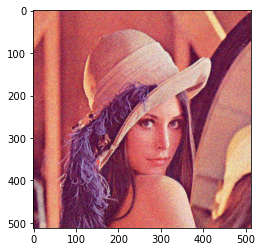

(<matplotlib.image.AxesImage at 0x1e34aabdb48>, None)

In [3]:
noisy_image_im = Image.open('../data/noisy.png')
noisy_image = np.array(noisy_image_im)/255.0

plt.imshow(noisy_image_im), plt.show()


# Setting NN models

#### - Setting the path of weights file

In [4]:
weights_path = 'trained_models/epoch_100/0.0001/'

#### - Check performance of prediction from trained model

In [5]:
def restore_image(trained_model, image):
    input_shape = (32,32,3)
    for row_idx in range(int(image.shape[0]/input_shape[0])):
        for col_idx in range(int(image.shape[1]/input_shape[1])):
            row_s = input_shape[0] * row_idx
            col_s = input_shape[1] * col_idx
            row_e = row_s + input_shape[0]
            col_e = col_s + input_shape[1]
            image_slice = image[row_s:row_e, col_s:col_e,:]
            
            
            restored_slice = trained_model.predict(np.array([image_slice]))[0]
            if col_idx == 0:
                restored_partition = restored_slice
            else:
                restored_partition = np.concatenate((restored_partition, restored_slice), axis=1)

        if row_idx == 0:
            restored_image = restored_partition
        else:
            restored_image = np.concatenate((restored_image, restored_partition), axis=0)
                
    return restored_image
        

In [6]:
def fully_restore_image(trained_model, image, skip_connection=None):
    input_shape = (32,32,3)
    interval_shape = (16,16)
    for row_idx in range(int(image.shape[0]/interval_shape[0])-1):
        for col_idx in range(int(image.shape[1]/interval_shape[1])-1):
            row_s = interval_shape[0] * row_idx
            col_s = interval_shape[1] * col_idx
            row_e = row_s + input_shape[0]
            col_e = col_s + input_shape[1]
            image_slice = image[row_s:row_e, col_s:col_e,:]
            
            
            restored_slice = trained_model.predict(np.array([image_slice]))[0]
            if col_idx == 0:
                restored_partition = restored_slice
            else:
                restored_partition = np.concatenate((restored_partition, restored_slice[:,interval_shape[1]:,:]), axis=1)
                for p_col in range(int(interval_shape[1]/2 + 1), interval_shape[1]):
                    d1 = (p_col - (interval_shape[1]+0.5))
                    d2 = (input_shape[1]+0.5 - p_col)
                    restored_partition[:,-p_col, :] = ( restored_partition[:, -p_col, :] * d1*d1*d1
                                                        + restored_slice[:,-p_col,:] * d2*d2*d2) / (d1*d1*d1+d2*d2*d2)
        if row_idx == 0:
            restored_image = restored_partition
        else:
            restored_image = np.concatenate((restored_image, restored_partition[interval_shape[0]:,:,:]), axis=0)
            for p_row in range(int(interval_shape[0]/2 + 1), interval_shape[0]):
                d1 = (p_row - (interval_shape[0]+0.5))
                d2 = (input_shape[0]+0.5 - p_row)
                restored_image[-p_row, :, :] = ( restored_image[-p_row, :, :] * d1*d1*d1
                                                    + restored_partition[-p_row, :, :] * d2*d2*d2) / (d1*d1*d1+d2*d2*d2)  
    return restored_image
        

## a) Model #1

#### - Build model

In [7]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

# load model
model_core.load_weights(weights_path + 'model1.hdf5')


#### - Show results

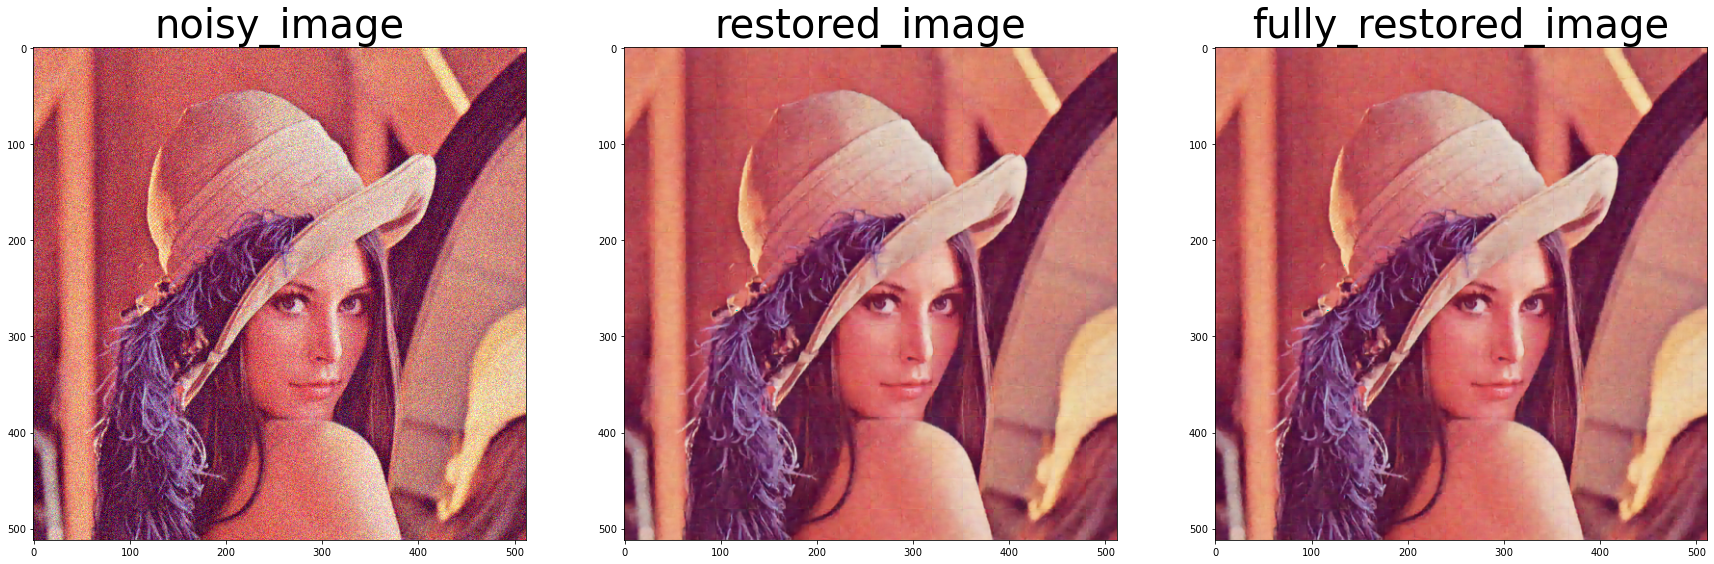

In [8]:
fig = plt.figure(figsize=(30,10))

# 0. noisy image
ax = fig.add_subplot(1,3, 1)
ax.imshow(noisy_image_im), ax.set_title('noisy_image', fontsize=40)

# 1. restored image
restored_image = restore_image(model_core, noisy_image)
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)
image_name = 'results/Model1_with_grid.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

ax = fig.add_subplot(1,3, 2)
ax.imshow(restored_image_im), ax.set_title('restored_image', fontsize=40)

# 2. fully restored image
restored_image = fully_restore_image(model_core, noisy_image)
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)
image_name = 'results/Model1.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

ax = fig.add_subplot(1,3, 3)
ax.imshow(restored_image_im), ax.set_title('fully_restored_image', fontsize=40)

fig.savefig('results/results_model1.jpeg')

### Model #2

#### - Build model

In [9]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

# load model
model_core.load_weights(weights_path + 'model2.hdf5')


#### - Show results

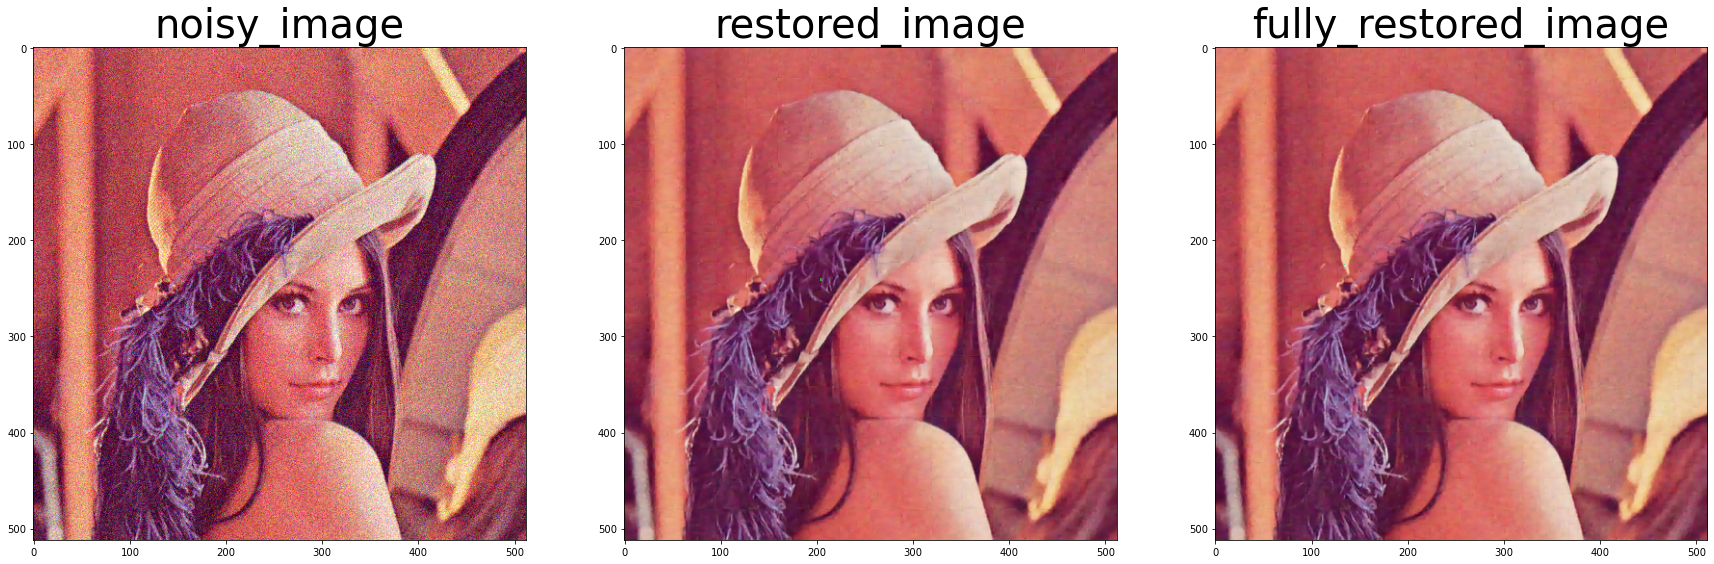

In [10]:
fig = plt.figure(figsize=(30,10))

# 0. noisy image
ax = fig.add_subplot(1,3, 1)
ax.imshow(noisy_image_im), ax.set_title('noisy_image', fontsize=40)

# 1. restored image
restored_image = noisy_image + restore_image(model_core, noisy_image)
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)
image_name = 'results/Model2_with_grid.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

ax = fig.add_subplot(1,3, 2)
ax.imshow(restored_image_im), ax.set_title('restored_image', fontsize=40)

# 2. fully restored image
restored_image = noisy_image + fully_restore_image(model_core, noisy_image)
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)
image_name = 'results/Model2.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

ax = fig.add_subplot(1,3, 3)
ax.imshow(restored_image_im), ax.set_title('fully_restored_image', fontsize=40)

fig.savefig('results/results_model2.jpeg')

### Model #3

#### - Build model

In [12]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

# load model
model_core.load_weights(weights_path + 'model3.hdf5')


#### - Show results

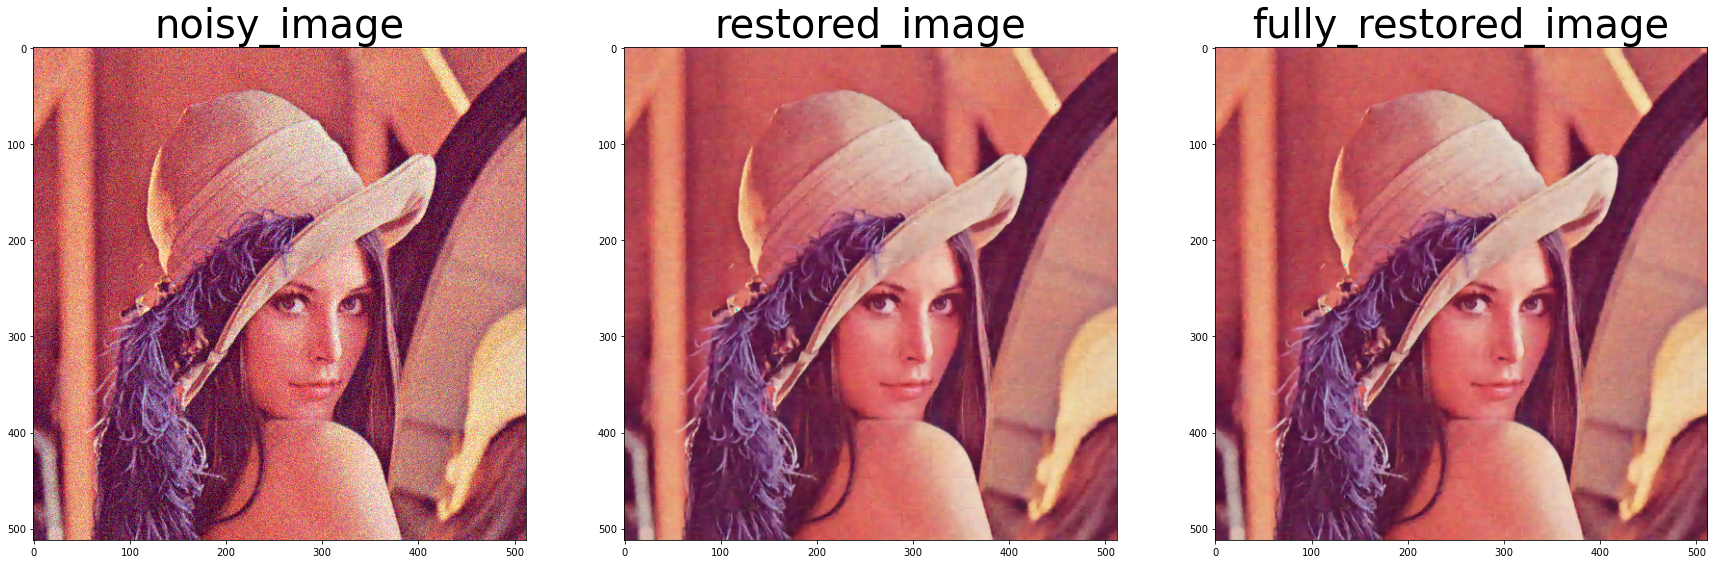

In [13]:
fig = plt.figure(figsize=(30,10))

# 0. noisy image
ax = fig.add_subplot(1,3, 1)
ax.imshow(noisy_image_im), ax.set_title('noisy_image', fontsize=40)

# 1. restored image
restored_image = noisy_image + restore_image(model_core, noisy_image)
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)
image_name = 'results/Model3_with_grid.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

ax = fig.add_subplot(1,3, 2)
ax.imshow(restored_image_im), ax.set_title('restored_image', fontsize=40)

# 2. fully restored image
restored_image = noisy_image + fully_restore_image(model_core, noisy_image)
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)
image_name = 'results/Model3.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

ax = fig.add_subplot(1,3, 3)
ax.imshow(restored_image_im), ax.set_title('fully_restored_image', fontsize=40)

fig.savefig('results/results_model3.jpeg')